<a href="https://colab.research.google.com/github/berkayouzhan/AI_Models/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network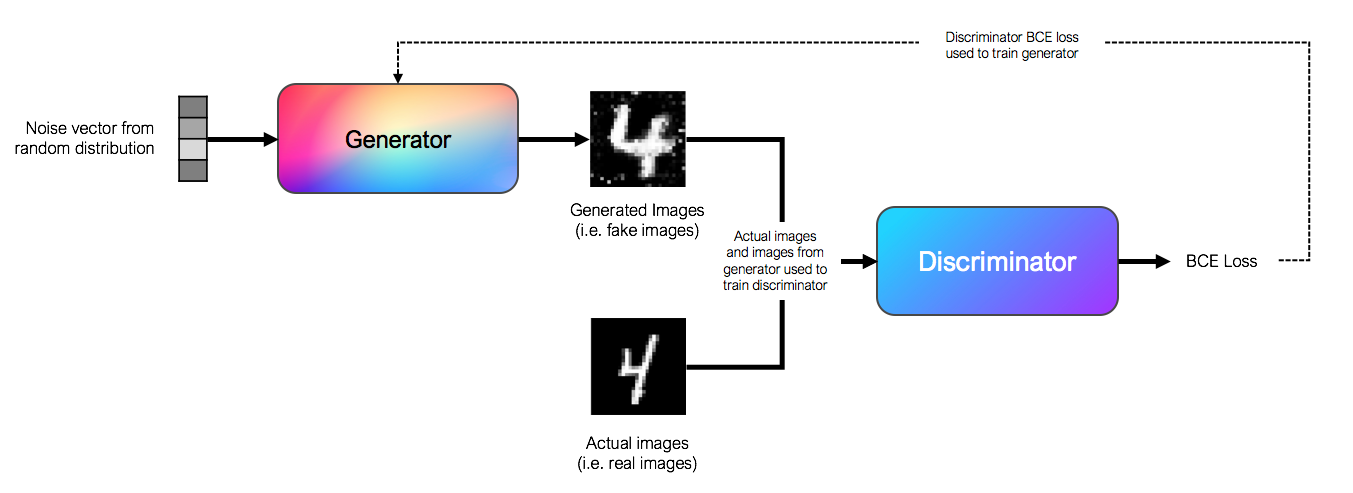

A Generative Adversarial Network (GAN) is a type of artificial intelligence model designed for generating new data that is similar to a given dataset. It consists of two main components: a generator and a discriminator.

1. **Generator:**
   - Takes random noise as input and generates synthetic data.
   - Aims to produce data that is indistinguishable from real data.

2. **Discriminator:**
   - Judges whether input data is real (from the actual dataset) or fake (generated by the generator).
   - Trained to improve its ability to differentiate between real and fake data.

3. **Training Process:**
   - The generator and discriminator are trained simultaneously in a competitive manner.
   - The generator improves its ability to produce realistic data to fool the discriminator.
   - The discriminator improves its ability to correctly classify real and fake data.

4. **Objective:**
   - Achieve a balance where the generator creates high-quality data that is difficult for the discriminator to distinguish from real data.
   - Results in the generation of data that closely resembles the original dataset.

5. **Applications:**
   - GANs are widely used in various applications such as image synthesis, style transfer, and data augmentation.
   - They have been influential in generating realistic images, art, and even text.

*In summary, GANs leverage the interplay between a generator and discriminator to produce synthetic data that is almost indistinguishable from real data. The training process involves continuous improvement of both components, leading to the creation of realistic and novel content.*

In [1]:
#Lets import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

In this part, the necessary libraries are imported. **PyTorch** is used for building deep learning models, **NumPy** for mathematical operations and data manipulation, and **matplotlib** for visualizations.

# Configurations

In [55]:
device = 'cuda' # image = image.to(device)

batch_size = 128 # trainloader, training loop

noise_dim = 64 # generator model

# optimizers parameters

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#training variables

epochs = 50

In this section, parameters for the model and training processes are defined.

The device variable determines which device will be used during training **(cuda: GPU, cpu: CPU)**.

**batch_size** enables processing training data in small groups.

**noise_dim** specifies the dimension of the random noise vector given to the generator.

lr, beta_1, and beta_2 are optimization parameters. epochs defines how many times the training loop will be repeated.

# LOADING THE DATASET

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([

    T.RandomRotation((-20,+20)),
    T.ToTensor() #(h,w,c) to (c,h,v)

]
)

In [5]:
trainset = datasets.MNIST('MNIST/', download = True , train = True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 165881505.95it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 58746699.24it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44103356.25it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23490171.11it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In this part, the **MNIST** dataset is loaded from the **torchvision** library. Data augmentation operations are defined using transforms.Compose.

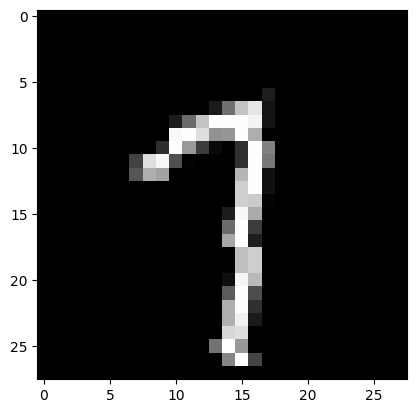

In [6]:
image, label = trainset[42]

plt.imshow(image.squeeze(), cmap = 'gray')

In [7]:
print("Total size of trainset is: ", len(trainset))

Total size of trainset is:  60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [10]:
print("Total number of batches in trainloader: ",len(trainloader))

Total number of batches in trainloader:  469


In [11]:
dataiter = iter(trainloader)

images, _ = dataiter.__next__()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
def show_tensor_images(tensor_img, num_images=16, size=(1,28,28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)

    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

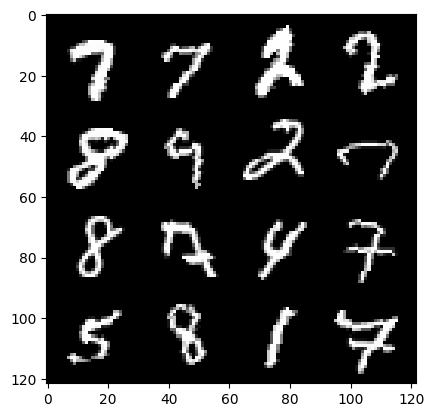

In [13]:
show_tensor_images(images, num_images=16)

The DataLoader is used to load training data in small batches (**batch_size**). An iterator is created using **iter(trainloader)** to get a batch of data with **__next__()** method. The show_tensor_images function visualizes these tensor images using matplotlib.

# Discriminator Network

In [14]:
from torch import nn
from torchsummary import summary

In [15]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [16]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)

    x5 = self.linear(x4)

    return x5

In this section, the discriminator network is defined. **get_disc_block** creates a block used in the discriminator. Then, using these blocks, the **Discriminator** class is created.

In [17]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Generator Network

### Lets try to understand how our Generator Network will work. :

In [18]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [33]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )


In [42]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim

    self.block_1 = get_gen_block(noise_dim, 256, (3,3),2)
    self.block_2 = get_gen_block(256, 128, (4,4),1)
    self.block_3 = get_gen_block(128, 64, (3,3),2)

    self.block_4 = get_gen_block(64, 1, (4,4),2, final_block = True)

  def forward(self, r_noise_vec):

    #(bs, noise_dim) ---->  (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim,1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4


Here, the generator network is defined. **get_gen_block** creates a block used in the generator. Then, using these blocks, the **Generator** class is created.

In [43]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [44]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [46]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In this part, the weights of the discriminator and generator models are initially set to random values and then transitioned to weights with a normal distribution using the **weights_init** function.

# Create Loss Function and Load Optimizer

In [52]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [49]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas= (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas= (beta_1, beta_2))

In this part, the weights of the discriminator and generator models are initially set to random values and then transitioned to weights with a normal distribution using the weights_init function.

# Training Loop

In this part, training is performed for a certain number of epochs. Within each epoch, the discriminator and generator models are trained in sequence by iterating over the training data. Outputs are displayed to observe how losses and generated images change as training progresses.

Epoch: 1 | D_loss: 0.6317947331522065 | G_loss: 0.8423449752935722


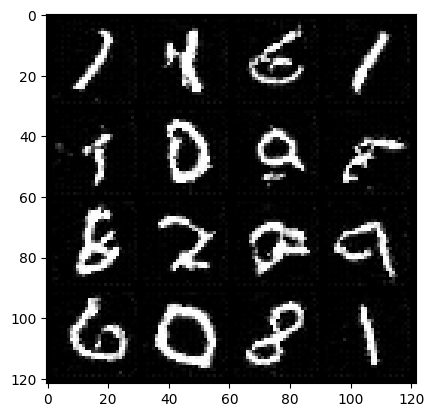

Epoch: 2 | D_loss: 0.6316210773707961 | G_loss: 0.8452790647681588


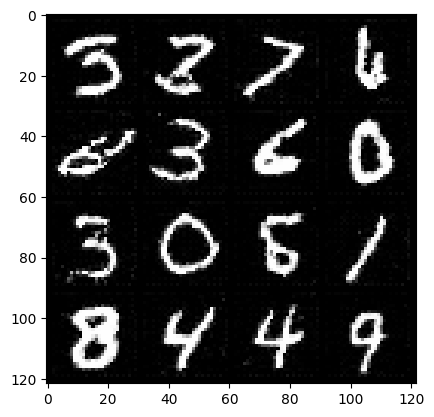

Epoch: 3 | D_loss: 0.628815482674377 | G_loss: 0.8487353746824936


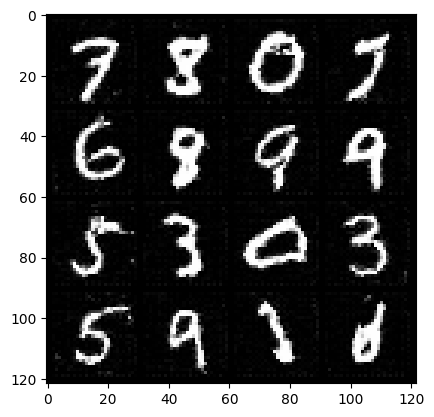

Epoch: 4 | D_loss: 0.6283022887162817 | G_loss: 0.8517200171566213


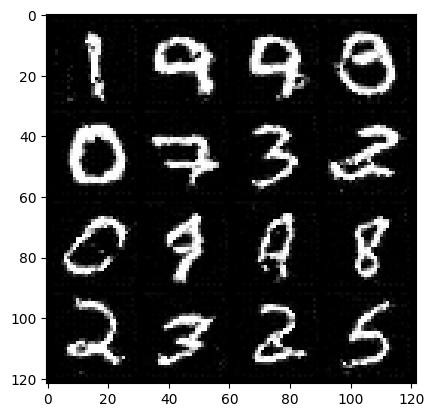

Epoch: 5 | D_loss: 0.6255882037982249 | G_loss: 0.8569331677483597


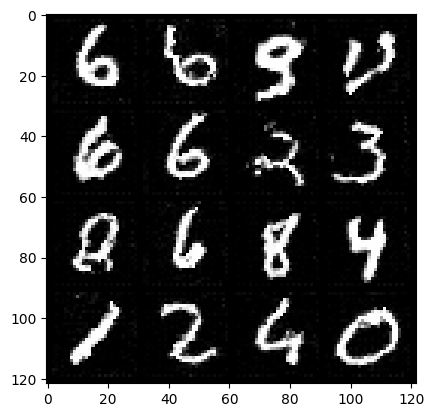

Epoch: 6 | D_loss: 0.6234303133319944 | G_loss: 0.8639891971148916


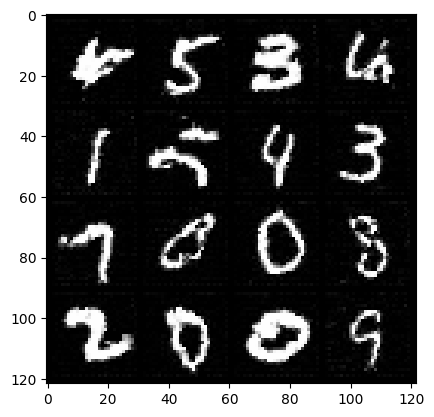

Epoch: 7 | D_loss: 0.6207652107230636 | G_loss: 0.8667562206162572


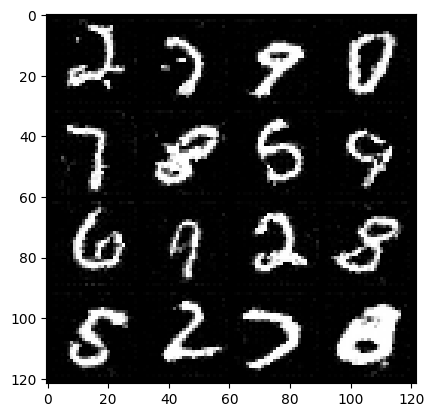

Epoch: 8 | D_loss: 0.6205425141716817 | G_loss: 0.8750092513017309


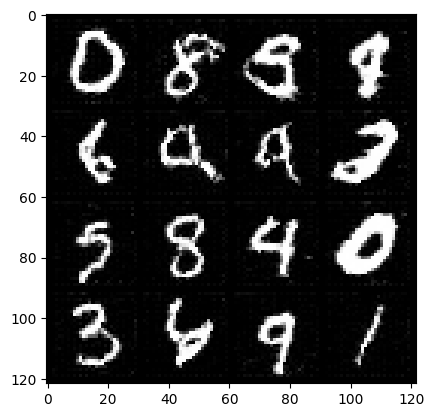

Epoch: 9 | D_loss: 0.618970419171014 | G_loss: 0.8787593129855483


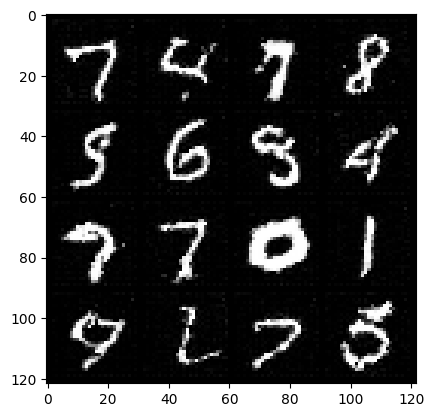

Epoch: 10 | D_loss: 0.6168144396119026 | G_loss: 0.8805112091463003


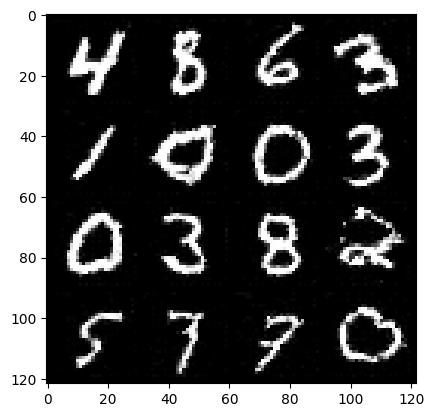

Epoch: 11 | D_loss: 0.6155459602504397 | G_loss: 0.8845517391334973


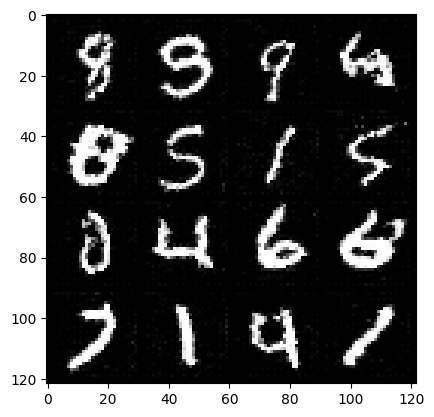

Epoch: 12 | D_loss: 0.6165696969672815 | G_loss: 0.8909105593715904


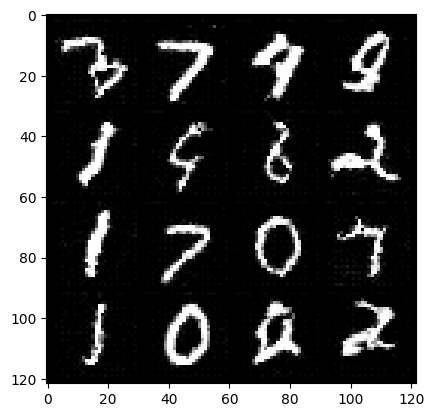

Epoch: 13 | D_loss: 0.6132478641548644 | G_loss: 0.8946107526832043


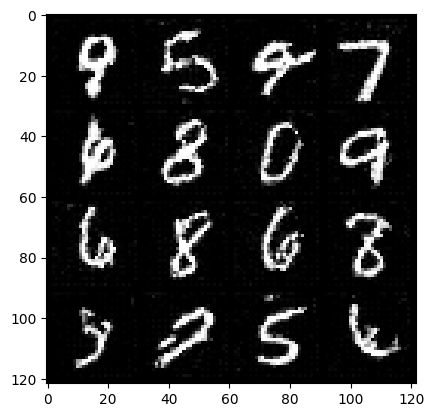

Epoch: 14 | D_loss: 0.6109730511077686 | G_loss: 0.9033484137388689


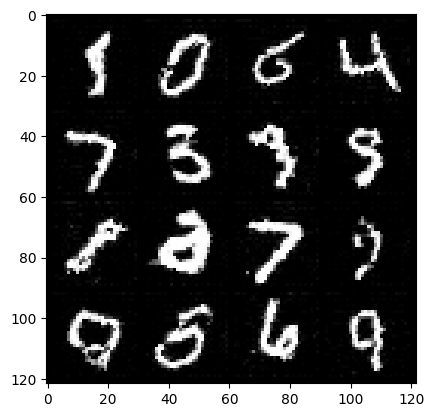

Epoch: 15 | D_loss: 0.6117247285873397 | G_loss: 0.905123795654728


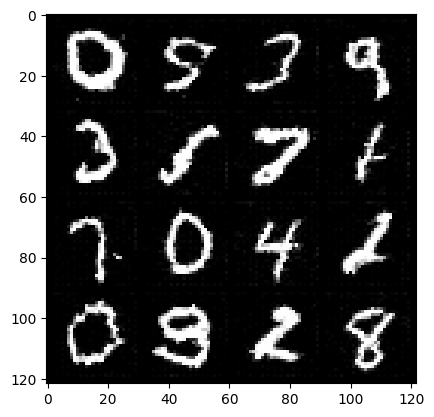

Epoch: 16 | D_loss: 0.6084452894196581 | G_loss: 0.9126295486747075


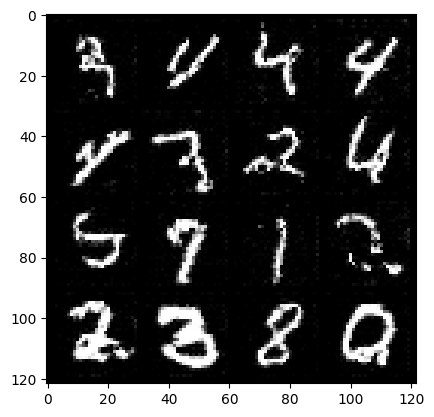

Epoch: 17 | D_loss: 0.6082809908049447 | G_loss: 0.9116953597394134


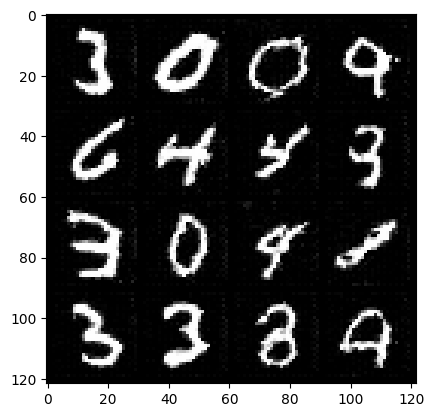

Epoch: 18 | D_loss: 0.6081048478958195 | G_loss: 0.9191696193935012


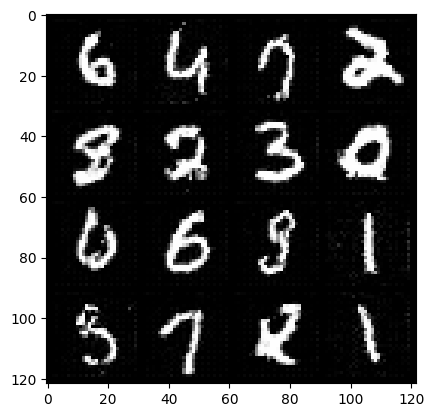

Epoch: 19 | D_loss: 0.6073095136359811 | G_loss: 0.9167142331218923


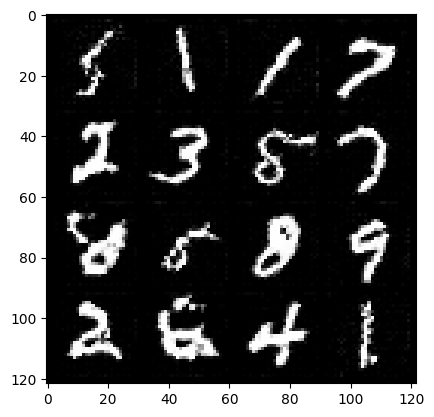

Epoch: 20 | D_loss: 0.6048906580217357 | G_loss: 0.926332329254923


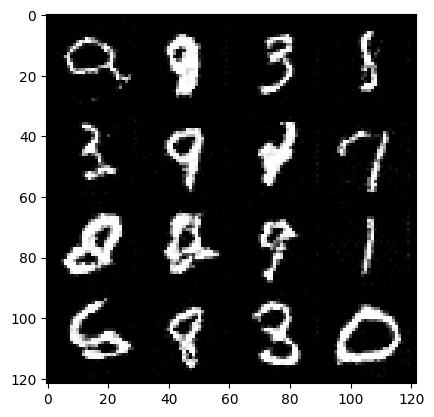

Epoch: 21 | D_loss: 0.6052482898301407 | G_loss: 0.9281217014865835


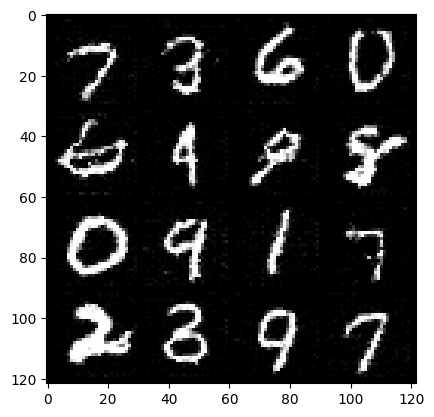

Epoch: 22 | D_loss: 0.6086572200250524 | G_loss: 0.9254606340739773


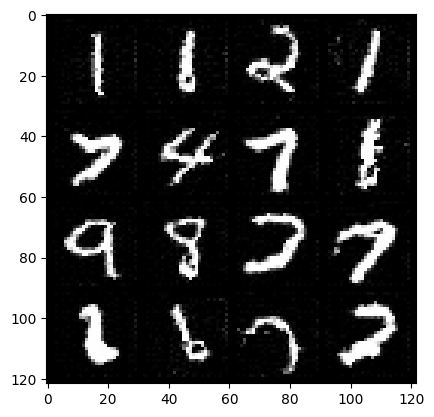

Epoch: 23 | D_loss: 0.604879880383579 | G_loss: 0.934035186701492


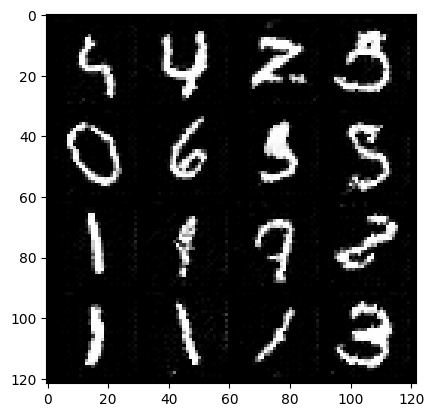

Epoch: 24 | D_loss: 0.6056856416435893 | G_loss: 0.933421969032491


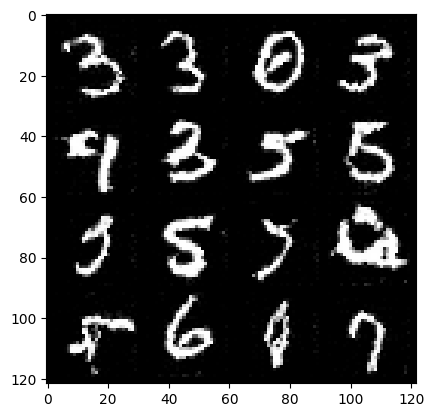

Epoch: 25 | D_loss: 0.6059060702954274 | G_loss: 0.9347832790061609


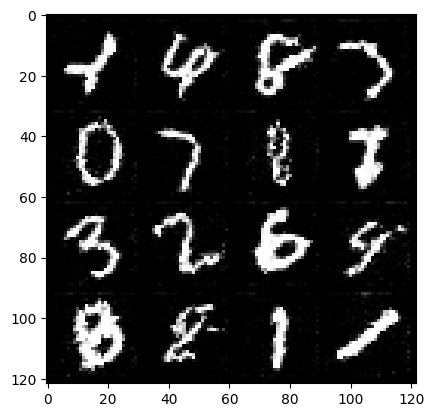

Epoch: 26 | D_loss: 0.6057932365423581 | G_loss: 0.9354840444603454


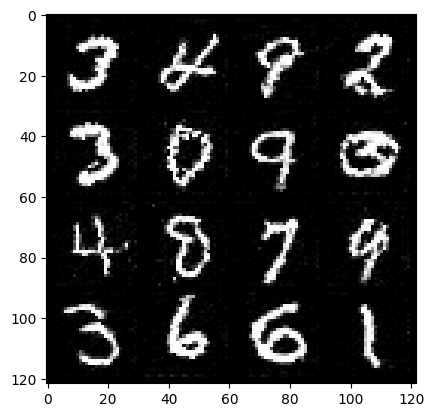

Epoch: 27 | D_loss: 0.606005013751577 | G_loss: 0.9367565499948286


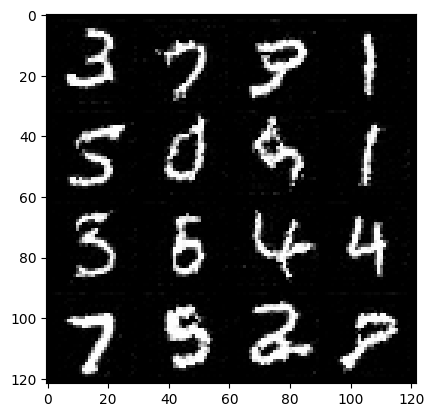

Epoch: 28 | D_loss: 0.6071152169821359 | G_loss: 0.9346337955135272


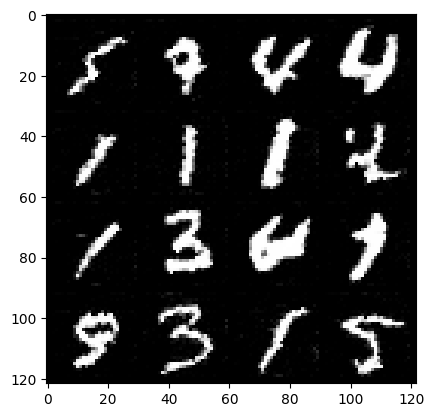

Epoch: 29 | D_loss: 0.6070808474697283 | G_loss: 0.940418772478856


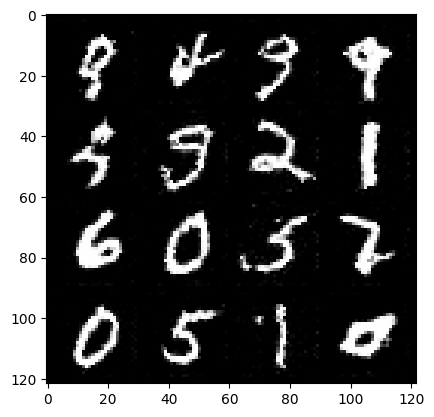

Epoch: 30 | D_loss: 0.6065936224547022 | G_loss: 0.9364982195246194


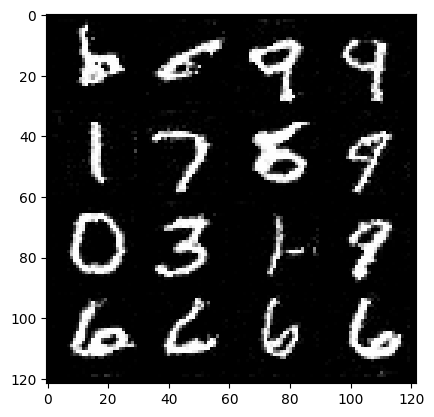

Epoch: 31 | D_loss: 0.6062033283176707 | G_loss: 0.9370003579013637


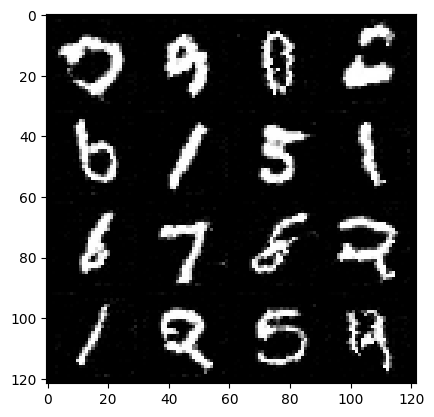

Epoch: 32 | D_loss: 0.6054027187290476 | G_loss: 0.9414608924627812


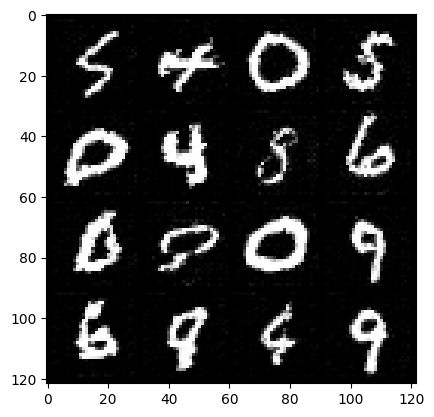

Epoch: 33 | D_loss: 0.6054490448823616 | G_loss: 0.9393966097567381


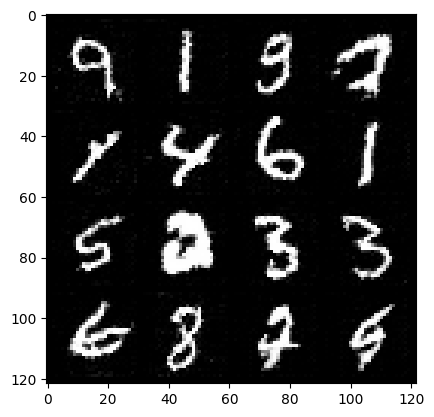

Epoch: 34 | D_loss: 0.6062289012520552 | G_loss: 0.937736063877911


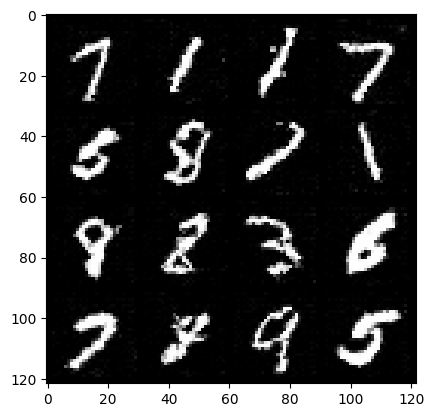

Epoch: 35 | D_loss: 0.6053940483501979 | G_loss: 0.9493856447846142


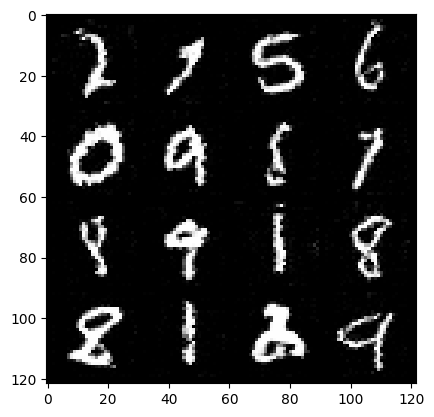

Epoch: 36 | D_loss: 0.6043930433706434 | G_loss: 0.9453758415636986


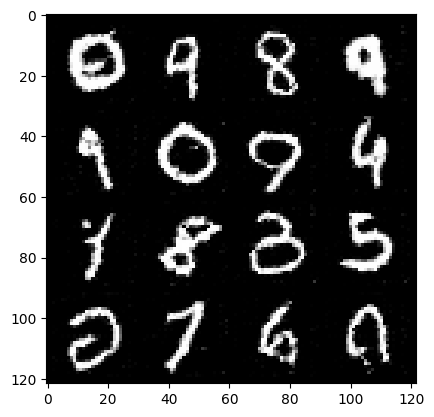

Epoch: 37 | D_loss: 0.6039970672206838 | G_loss: 0.9586220749659833


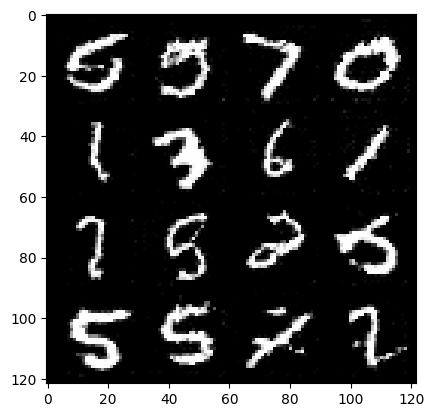

Epoch: 38 | D_loss: 0.604543255971693 | G_loss: 0.9456080404171812


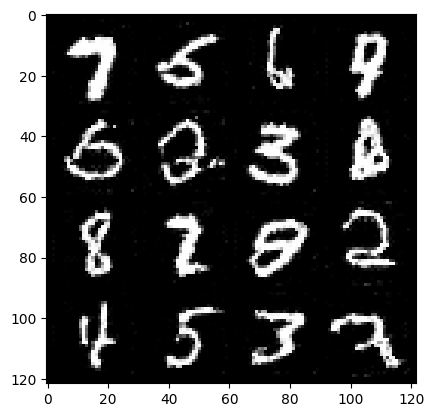

Epoch: 39 | D_loss: 0.6039898691655222 | G_loss: 0.9552821589431275


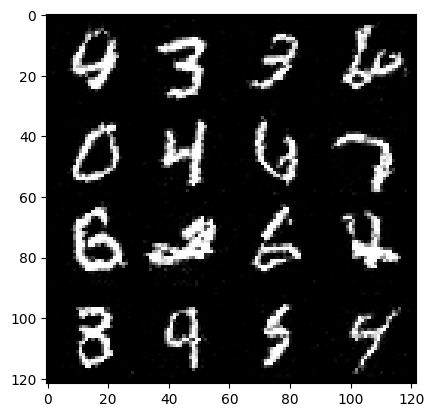

Epoch: 40 | D_loss: 0.6033624293707581 | G_loss: 0.9559294569975277


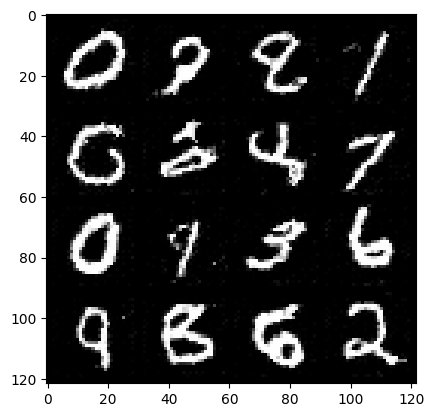

Epoch: 41 | D_loss: 0.60156845703308 | G_loss: 0.9568694256770331


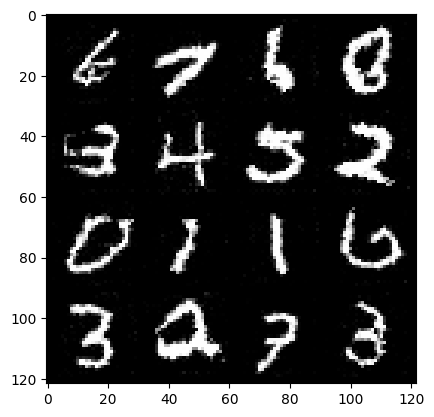

Epoch: 42 | D_loss: 0.6003473517991332 | G_loss: 0.9616550916293537


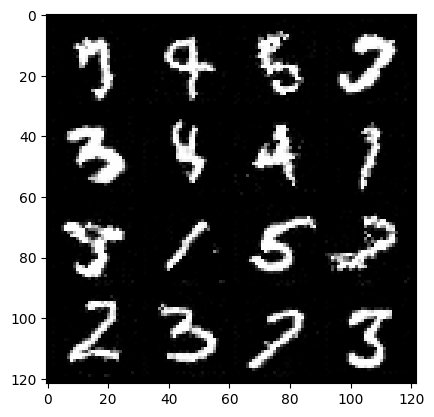

Epoch: 43 | D_loss: 0.602284016766782 | G_loss: 0.9656942733315262


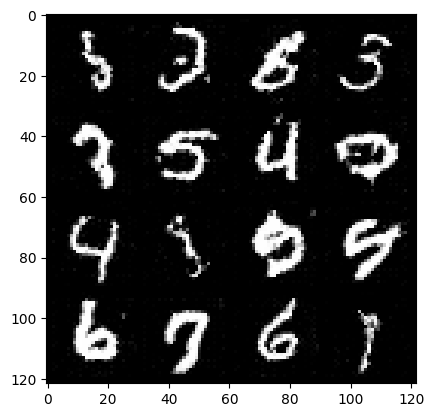

Epoch: 44 | D_loss: 0.601915366486954 | G_loss: 0.9601863151165977


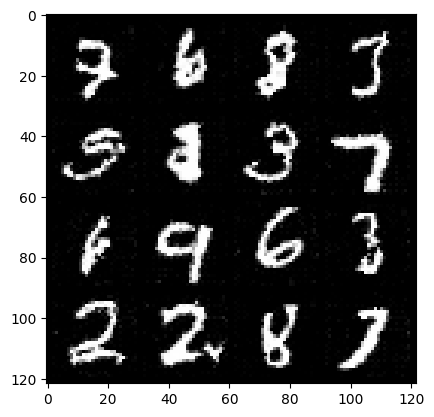

Epoch: 45 | D_loss: 0.6036312951207924 | G_loss: 0.9599772150328418


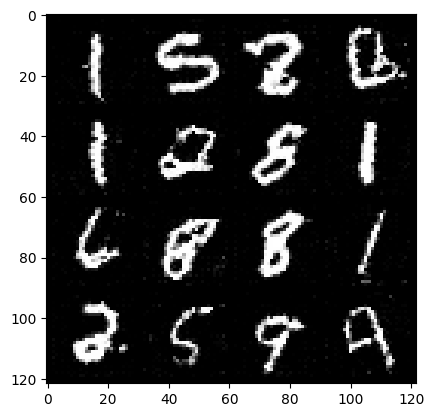

Epoch: 46 | D_loss: 0.602444506149048 | G_loss: 0.9647553490677367


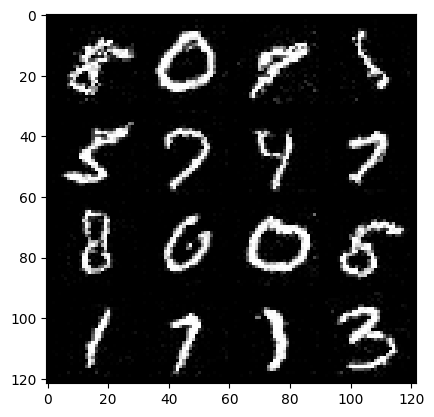

Epoch: 47 | D_loss: 0.6020652556470208 | G_loss: 0.9605845167184435


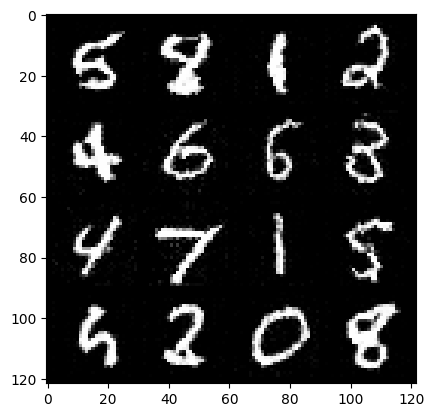

Epoch: 48 | D_loss: 0.6027691702344524 | G_loss: 0.9615759934697833


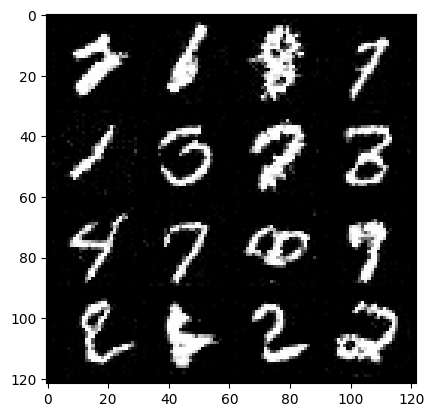

Epoch: 49 | D_loss: 0.601677931193858 | G_loss: 0.9663549664178128


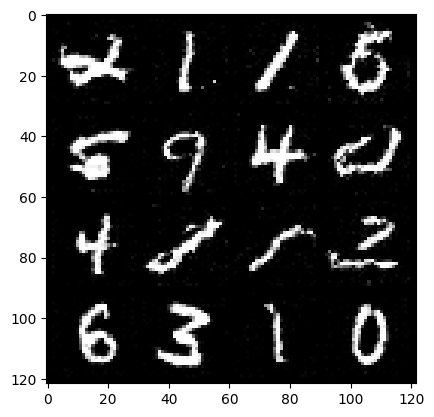

Epoch: 50 | D_loss: 0.6034743203791474 | G_loss: 0.9611517908984918


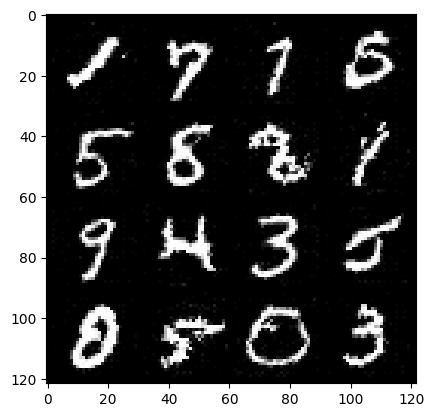

In [56]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in (trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

#finding loss and updating weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred= D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()


#finding loss and updating weights for G

    G_opt.zero_grad()

    noise= torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

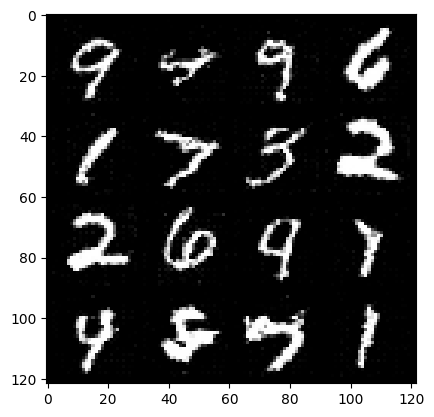

In [59]:
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)